In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wbdata
import seaborn as sns

# Child marriage

Chil marriage over the past years (2007-2017), has child marriage dropped? (marriage before 15 and marriage before 18 (data checking/ fact checking) and if this rate contineous, will goal 5.3 be reached in 2030?(extrapoleren):
    - Child marriage percentage per country over time 
        -How was it in the past
        -how is it now
        -how will it develop over time

#### Deze data laat zien hoe het er nu voor staat met het aantal child marriages

This data shows the percentage of women who were first married by the age of 15.

In [3]:
married15_all = pd.DataFrame(wbdata.get_data("SP.M15.2024.FE.ZS"))
married15_all['country'] = married15_all.country.astype(str).str.slice(23,-2)
married15_all['indicator'] = married15_all.indicator.astype(str).str.slice(35,-2)
married15_all['value'] = married15_all.value.astype(float).round(1)


#find rows where the value is greater than 0
married15_all = married15_all.loc[(married15_all["value"] >= 0)]

#find the rows with the most recent data
married15_now = married15_all.sort_values("date", ascending = False).drop_duplicates(["country"])
married15_now["date"] = married15_now.date.astype(str)

Because we only look at the top 15 countries with the lowest equality rate. A new dataframe is made only containing the countries with this low equality rate compared.

In [4]:
CPIA_worst15 = pd.read_csv("CPIA_worst15.csv")
CPIA_worst15["date"] = CPIA_worst15["date"].astype(str)    

In [14]:
# Omdat er geen data is van 2017, heb ik de meeest recente data gebruikt. Zelfs hiervan is missing data.

married15_worst15 = pd.merge( CPIA_worst15, married15_now, how = "left", left_on = ["country"], right_on = ["country"])

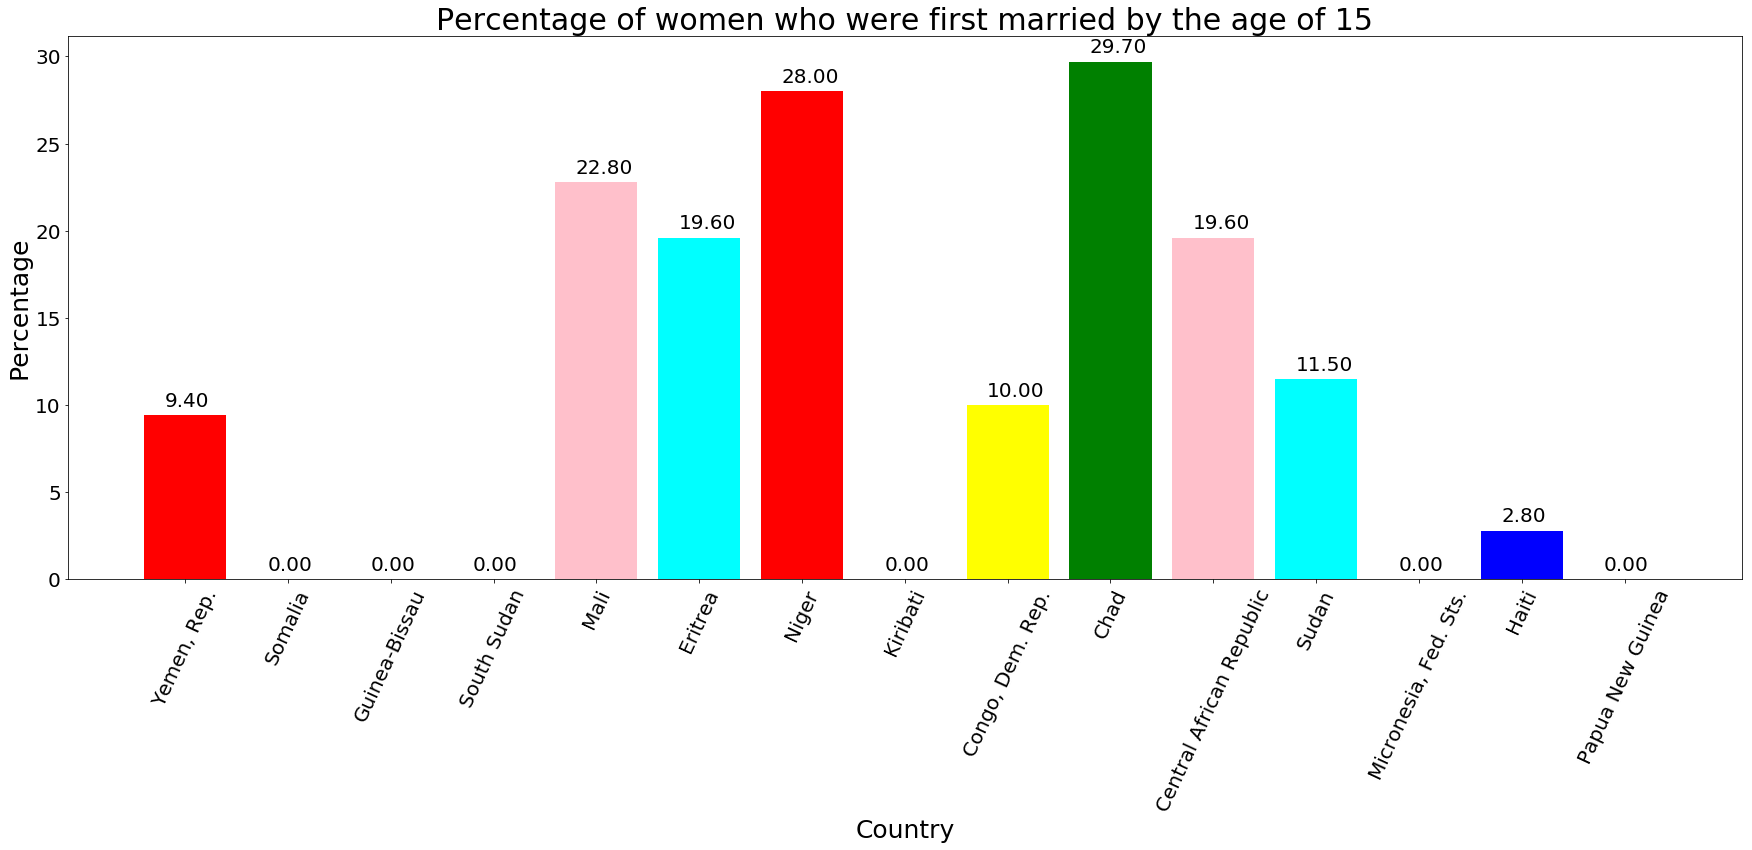

In [20]:
# bar plot van de 15 landen. 

# jaartal van data van married 15 moet nog in de bar plot, aangezien geen data beschikbaar is van 2017. 
# Hiervan moeten we misschien ook nog andere dataset gebruiken, zodat deze aangevuld kan worden. 
# Misschien dat we dan wel recentere data kunnen gebruiken

#married15_worst15.plot(kind="bar", x = "country", y = "value_y", legend = False)
    
# array maken van de twee kolommen die nuttig zijn 
country_married_worst15 = married15_worst15.country.values
value_married_worst15 = married15_worst15.value_y.values

colors = ["Red", "Blue", "Yellow", "Green", "Pink", "Cyan"]

value_married_worst15[np.isnan(value_married_worst15)] = 0

plt.figure(figsize=(30, 10))
plt.bar(country_married_worst15, value_married_worst15, color = colors, width = 0.8, align='center')

#tekst onder x-as is gek!
plt.xticks(rotation = 65, fontsize = 20)
plt.yticks(fontsize = 20)

plt.title("Percentage of women who were first married by the age of 15" , fontsize = 30)
plt.xlabel("Country" , fontsize = 25)
plt.ylabel("Percentage" , fontsize = 25)


# De waarde van het land bovenop bar
for (i, value) in enumerate (value_married_worst15):
    plt.text(i- 0.2 , value + 0.5 , "%.2f" % (value) , fontsize = 20)

In [7]:
# missing values aanvullen met een andere database?
# visualiseren dat de data van married 15 van sommige landen niet recent is. 


#### Data van vroeger tot nu

In [26]:
# married15_all gebruiken om te kunnen laten zien hoe het aantal kindhuwelijken over de jaren heen is veranderd

married15_years = married15_all.loc[((married15_all["country"].isin(CPIA_worst15["country"]))),:].sort_values(by = "date", ascending = True)

married15_years["date"] = married15_years["date"].astype(int)

#drop rows with date < 2000 
married15_lowerYears = married15_years[married15_years['date'] < 2000]
married15_years = married15_years.drop(married15_lowerYears.index, axis = 0)

married15_years.head()



,country,date,decimal,indicator,value
7615,Haiti,2000,2,: 'Women who were first married by age 15 (% o...,5.3
9876,Mali,2001,2,: 'Women who were first married by age 15 (% o...,24.5
6279,Eritrea,2002,2,: 'Women who were first married by age 15 (% o...,19.6
4943,Chad,2004,2,: 'Women who were first married by age 15 (% o...,34.5
7609,Haiti,2006,2,: 'Women who were first married by age 15 (% o...,5.6


#### Deze landen missen in married 15!
1                      Somalia
2                Guinea-Bissau
3                  South Sudan
7                     Kiribati
12       Micronesia, Fed. Sts.
14            Papua New Guinea

Text(0,0.5,'Percentage')

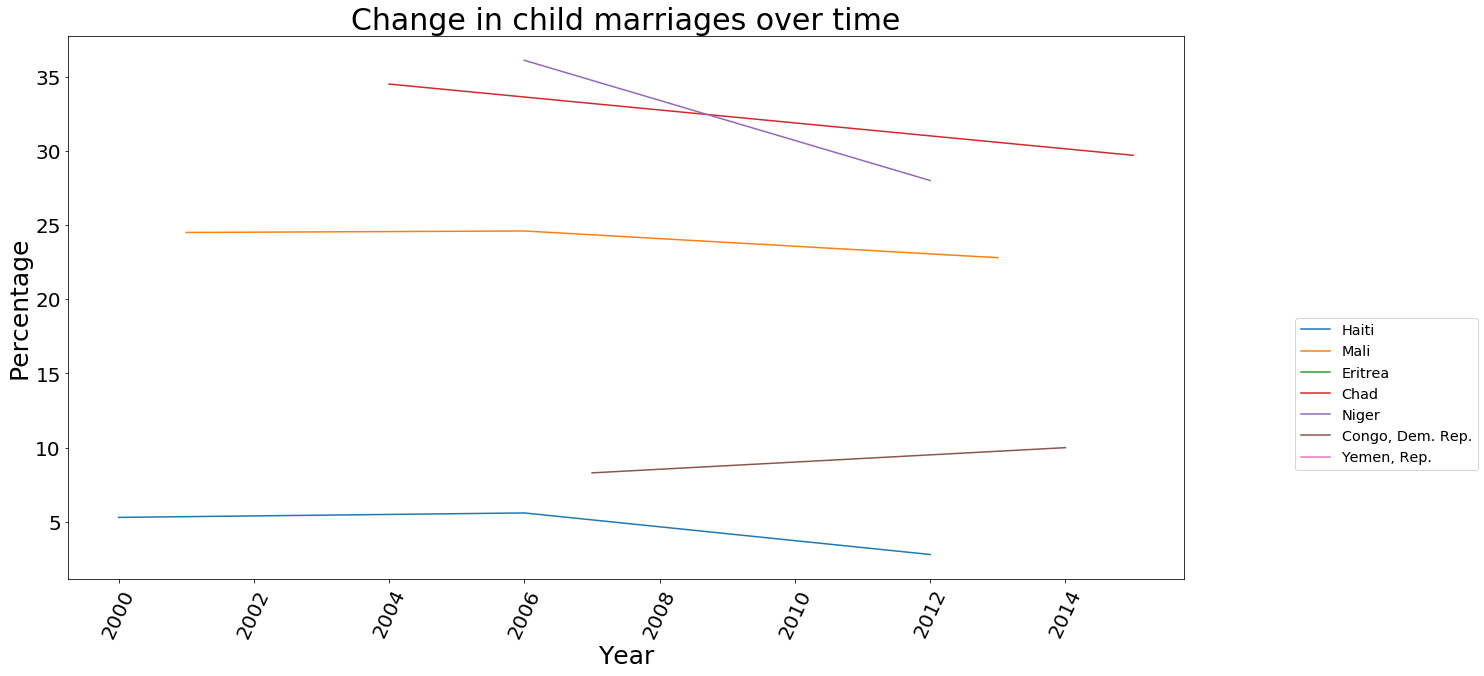

In [29]:
# visualiseren van verandering per land

fig1,ax1 = plt.subplots(figsize=(20, 10))

for name in married15_years["country"].unique():
    ax1.plot(married15_years[married15_years.country==name].date,married15_years[married15_years.country==name].value,label=name)

#change size and location of legend
ax1.legend(loc=(1.1, 0.2), fontsize = 'x-large')

#tekst op x en y-as
plt.xticks(rotation = 65, fontsize = 20)
plt.yticks(fontsize = 20)

#labels
plt.title("Change in child marriages over time", fontsize = 30)
plt.xlabel("Year", fontsize = 25)
plt.ylabel("Percentage", fontsize = 25)

# stapgrootte x-as

#### Interpoleren

In [21]:
#volgens mij is dit niet nodig
# date = married15_past.loc[married15_past["country"] == "Mali"]["date"].values
# value =  married15_past.loc[married15_past["country"] == "Mali"]["value"].values

# np.interp(2001, 'date', 'value')

#### Extrapoleren

In [22]:
# make array out of dataframe
# date = married15_past.loc[married15_past["country"] == "Mali"]["date"].values
# value =  married15_past.loc[married15_past["country"] == "Mali"]["value"].values

# z = np.polyval((np.polyfit(married15_past["date"], married15_past["value"], 10)), 10)
# new_value = np.append(value, z)

# plt.plot(date, value)
